# 데이터 중복 값 처리

- [코드 참고 사이트](https://www.kaggle.com/code/icfoer/ps6e7-xgboost-leak)


1. 모든 데이터를 살려는 방법
  - 둘 중 하나의 방법을 선택
  - 1. 중복 값의 예약은 취소로, 취소는 예약으로 바꾸기
  - 2. 중복 값을 0.5( 평균 값 )로 바꾸기 - 포기

2. 중복 데이터 버리는 방법

## 데이터 준비

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train      = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/train.csv' )
test       = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/test.csv' )
submission = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/sample_submission.csv' )

train.shape, test.shape, submission.shape

((42100, 19), (28068, 18), (28068, 2))

### 데이터 복사본 생성

In [ ]:
# train, test 데이터 복사본 생성
copy_train = train.copy( )
copy_test = test.copy( )

copy_train.head( )

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [ ]:
copy_test.head( )

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2
1,42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0
2,42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1
3,42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0
4,42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0


## 1. 모든 데이터 살리기

### 1-1. 중복 값의 예약은 취소로, 취소는 예약으로 바꾸기

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train      = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/train.csv' )
test       = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/test.csv' )
submission = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/sample_submission.csv' )
extra_data = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/train__dataset.csv' )

train.shape, test.shape, submission.shape, extra_data.shape

((42100, 19), (28068, 18), (28068, 2), (18137, 18))

In [ ]:
copy_train = train.copy( )
copy_test  = test.copy( )

In [ ]:
df = copy_train
test_df = copy_test
adf = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/train__dataset.csv' )

# 'generated_type' 열 추가
df[ 'generated_type' ] = 1
test_df[ 'generated_type' ] = 1
adf[ 'generated_type' ] = 0

# 중복을 확인할 열들 정의
dup_features = [ 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
                 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
                 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
                 'arrival_date', 'market_segment_type', 'repeated_guest',
                 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
                 'avg_price_per_room', 'no_of_special_requests' ]


# 데이터프레임 합치기 및 중복 값 처리
df = pd.concat( [ df, adf ], ignore_index = True ).drop( 'id', axis = 1 ).reset_index( drop = True )
nod = df[ dup_features ].duplicated( ).sum( )
nod_with_target = df[ dup_features + [ 'booking_status' ] ].duplicated( ).sum( )


# 중복 값이 있는 경우 테스트 데이터의 값을 반대로 바꿈
# del_df = df.drop(test_leakage['id_train']).reset_index(drop=True)
# nod_with_target.loc[nod_with_target.index.isin(test_leakage['id_train']), 'booking_status'] = 1 - nod_with_target.loc[nod_with_target.index.isin(test_leakage['id_train']), 'booking_status']
# 중복 값 변환
for feature in dup_features:
  if df[ feature ].isin( df[ df.duplicated( subset = dup_features ) ][ 'booking_status' ] ).all( ):
    df.loc[ df.duplicated( subset = dup_features ), 'booking_status' ] = 1 - df.loc[ df.duplicated( subset = dup_features ), 'booking_status' ]


# 누출 데이터 제거
tt = df.reset_index( ).rename( columns = { "index" : "id" } ).drop( 'booking_status', axis = 1 )
test_leakage = test_df.merge( tt, on = [ c for c in test_df.columns if c != 'id' ], how = 'inner', suffixes = [ '_test', '_train' ] )[ [ 'id_test', 'id_train' ] ]
df = df.drop( test_leakage[ 'id_train' ] ).reset_index( drop = True )

# 결과 출력
print( f'#duplicates = { nod }, #duplicates with different target = { nod_with_target }, #leakage = { test_leakage.shape[ 0 ] }' )


#duplicates = 6516, #duplicates with different target = 5664, #leakage = 716


In [ ]:
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,generated_type
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,1
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,1
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,1
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,1
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59516,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1,0
59517,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0,0
59518,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1,0
59519,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0,0


In [ ]:
df.to_csv( "change_train.csv", index = False )

### 1-2. 중복 데이터 0.5로 변경

In [ ]:
df = copy_train
test_df = copy_test
adf = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/train__dataset.csv' )

# 'generated_type' 열 추가
df[ 'generated_type' ] = 1
test_df[ 'generated_type' ] = 1
adf[ 'generated_type' ] = 0

# 중복을 확인할 열들 정의
dup_features = [ 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
                 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
                 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
                 'arrival_date', 'market_segment_type', 'repeated_guest',
                 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
                'avg_price_per_room', 'no_of_special_requests' ]

# 데이터프레임 합치기 및 중복 값 처리
df = pd.concat( [ df, adf ], ignore_index = True ).drop( 'id', axis = 1 ).reset_index( drop = True )
nod = df[ dup_features ].duplicated( ).sum( )
nod_with_target = df[ dup_features + [ 'booking_status' ] ].duplicated( ).sum( )
df.loc[ df.duplicated( subset = dup_features ), : ] = 0.5

# 누출 데이터 제거
tt = df.reset_index( ).rename( columns = { "index" : "id" } ).drop( 'booking_status', axis = 1 )
test_leakage = test_df.merge( tt, on = [ c for c in test_df.columns if c != 'id' ], how = 'inner', suffixes = [ '_test', '_train' ] )[ [ 'id_test', 'id_train' ] ]
df = df.drop( test_leakage[ 'id_train' ] ).reset_index( drop = True )

# 결과 출력
print( f'#duplicates = { nod }, #duplicates with different target = { nod_with_target }, #leakage = { test_leakage.shape[ 0 ] }' )

<ipython-input-13-ae4a89a55250>:26: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  test_leakage = test_df.merge(tt, on=[c for c in test_df.columns if c != 'id'], how='inner', suffixes=['_test', '_train'])[['id_test', 'id_train']]


#duplicates = 6516, #duplicates with different target = 5664, #leakage = 716


In [ ]:
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,generated_type
0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,9.0,2018.0,1.0,14.0,1.0,1.0,11.0,0.0,67.50,0.0,0.0,1.0
1,2.0,0.0,1.0,2.0,0.0,0.0,0.0,117.0,2018.0,7.0,29.0,0.0,0.0,0.0,0.0,72.25,0.0,0.0,1.0
2,2.0,0.0,0.0,1.0,0.0,0.0,0.0,315.0,2018.0,12.0,2.0,0.0,0.0,0.0,0.0,52.00,0.0,0.0,1.0
3,1.0,0.0,0.0,2.0,1.0,0.0,0.0,32.0,2018.0,12.0,1.0,1.0,0.0,0.0,0.0,56.00,0.0,0.0,1.0
4,2.0,0.0,1.0,0.0,0.0,0.0,0.0,258.0,2018.0,10.0,16.0,0.0,0.0,0.0,0.0,100.00,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59516,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.50,0.5,0.5,0.5
59517,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.50,0.5,0.5,0.5
59518,2.0,0.0,0.0,1.0,0.0,0.0,0.0,90.0,2018.0,7.0,13.0,1.0,0.0,0.0,0.0,105.30,0.0,1.0,0.0
59519,2.0,0.0,0.0,3.0,0.0,0.0,0.0,18.0,2018.0,11.0,10.0,1.0,1.0,0.0,1.0,123.33,1.0,0.0,0.0


In [ ]:
test_df

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,generated_type
0,42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2,1
1,42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0,1
2,42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1,1
3,42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0,1
4,42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,70163,2,0,1,2,0,0,0,315,2018,9,30,1,0,0,0,160.00,0,1
28064,70164,2,0,2,2,0,0,0,81,2018,3,25,0,0,0,0,65.00,1,1
28065,70165,2,0,1,2,0,0,0,40,2018,10,22,0,0,0,0,85.00,0,1
28066,70166,3,0,0,4,0,0,1,4,2018,9,6,1,0,0,0,162.75,0,1


In [ ]:
adf

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,generated_type
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1,0
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1,0
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1,0
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1,0
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1,0
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0,0


In [ ]:
df.to_csv( "0.5train.csv", index = False )
test_df.to_csv( "0.5test.csv", index = False )

## 2. 중복 데이터 삭제

In [ ]:
df = copy_train
test_df = copy_test
adf = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/train__dataset.csv' )

# 'generated_type' 열 추가
df[ 'generated_type' ] = 1
test_df[ 'generated_type' ] = 1
adf[ 'generated_type' ] = 0

# 중복을 확인할 열들 정의
dup_features = [ 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
                 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
                 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
                 'arrival_date', 'market_segment_type', 'repeated_guest',
                 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
                 'avg_price_per_room', 'no_of_special_requests' ]

# 데이터프레임 합치기 및 중복 값 처리
df = pd.concat( [ df, adf ], ignore_index = True ).drop( 'id', axis = 1 ).reset_index( drop = True )
nod = df[ dup_features ].duplicated( ).sum( )
nod_with_target = df[ dup_features + [ 'booking_status' ] ].duplicated( ).sum( )
df = df.drop_duplicates( subset = dup_features ).reset_index( drop = True )

# 누출 데이터 제거
tt = df.reset_index( ).rename( columns = { "index" : "id" } ).drop( 'booking_status', axis = 1 )
test_leakage = test_df.merge( tt, on = [ c for c in test_df.columns if c != 'id' ], how = 'inner', suffixes = [ '_test', '_train' ] )[ [ 'id_test', 'id_train' ] ]
del_df = df.drop( test_leakage[ 'id_train' ] ).reset_index( drop = True )

# 결과 출력
print( f'#duplicates = { nod }, #duplicates with different target = { nod_with_target }, #leakage = { test_leakage.shape[ 0 ] }' )


#duplicates = 6516, #duplicates with different target = 5664, #leakage = 716


In [ ]:
del_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,generated_type
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,1
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,1
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,1
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,1
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53000,2,0,0,1,1,0,0,4,2018,2,13,1,0,0,0,79.00,0,0,0
53001,2,0,1,1,2,0,0,35,2018,10,15,1,0,0,0,148.60,2,0,0
53002,2,0,0,5,0,0,0,205,2018,7,26,1,0,0,0,70.03,1,1,0
53003,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1,0


In [ ]:
test_df

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,generated_type
0,42100,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2,1
1,42101,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0,1
2,42102,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1,1
3,42103,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0,1
4,42104,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,70163,2,0,1,2,0,0,0,315,2018,9,30,1,0,0,0,160.00,0,1
28064,70164,2,0,2,2,0,0,0,81,2018,3,25,0,0,0,0,65.00,1,1
28065,70165,2,0,1,2,0,0,0,40,2018,10,22,0,0,0,0,85.00,0,1
28066,70166,3,0,0,4,0,0,1,4,2018,9,6,1,0,0,0,162.75,0,1


In [ ]:
adf

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,generated_type
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1,0
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1,0
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1,0
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1,0
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1,0
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0,0


In [ ]:
del_df.to_csv( "del_train.csv", index = False )

# EDA

## 1. 중복 값의 예약은 취소로, 취소는 예약으로 바꾸기

### 데이터 준비

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train      = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/change_train.csv' )
target = train[ 'booking_status' ]

### 범주형 변수 - 타겟 변수의 모든 표 형식

In [ ]:
for i, feature in enumerate( cate_features ):
  if i != 9:
    print( f'{ feature }' )
    display_tabular_relationship_cate_target( train, feature )
    print( '\n' )

no_of_adults


no_of_adults,0,1,2,3,4
booking_status,,,,,
0,0.645299,0.738286,0.605786,0.597155,0.631579
1,0.354701,0.261714,0.394214,0.402845,0.368421




no_of_children


no_of_children,0,1,2,3,4,9
booking_status,,,,,,
0,0.631322,0.622881,0.580798,0.814815,0.8,0.75
1,0.368678,0.377119,0.419202,0.185185,0.2,0.25




type_of_meal_plan


type_of_meal_plan,0,1,2,3
booking_status,,,,
0,0.643342,0.542038,0.588655,0.888889
1,0.356658,0.457962,0.411345,0.111111




required_car_parking_space


required_car_parking_space,0,1
booking_status,,
0,0.621508,0.899144
1,0.378492,0.100856




room_type_reserved


room_type_reserved,0,1,2,3,4,5,6
booking_status,,,,,,,
0,0.63228,0.610379,0.679837,0.583588,0.732426,0.857678,0.666667
1,0.36772,0.389621,0.320163,0.416412,0.267574,0.142322,0.333333




arrival_year


arrival_year,2017,2018
booking_status,,
0,0.837085,0.591146
1,0.162915,0.408854




market_segment_type


market_segment_type,0,1,2,3,4
booking_status,,,,,
0,0.761977,0.537828,0.887776,0.772727,0.989062
1,0.238023,0.462172,0.112224,0.227273,0.010937




repeated_guest


repeated_guest,0,1
booking_status,,
0,0.618652,0.989311
1,0.381348,0.010689




no_of_special_requests


no_of_special_requests,0,1,2,3,4,5
booking_status,,,,,,
0,0.537627,0.715387,0.797567,0.994914,1.0,1.0
1,0.462373,0.284613,0.202433,0.005086,0.0,0.0


### 예약 상태의 비율 바차트

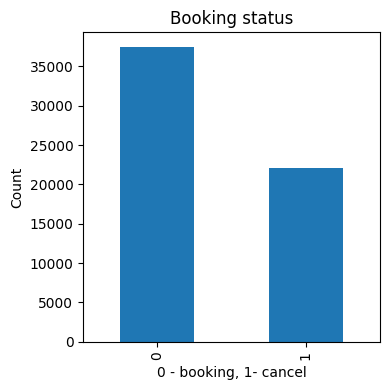

In [ ]:
ax = target.value_counts( ).plot.bar( figsize = ( 4, 4 ), legend = False )
ax.set_title( 'Booking status' )
ax.set_xlabel( '0 - booking, 1- cancel' )
ax.set_ylabel( 'Count' )
plt.tight_layout( )
plt.show( )

### 예약 상태와 특성

<Figure size 1200x800 with 0 Axes>

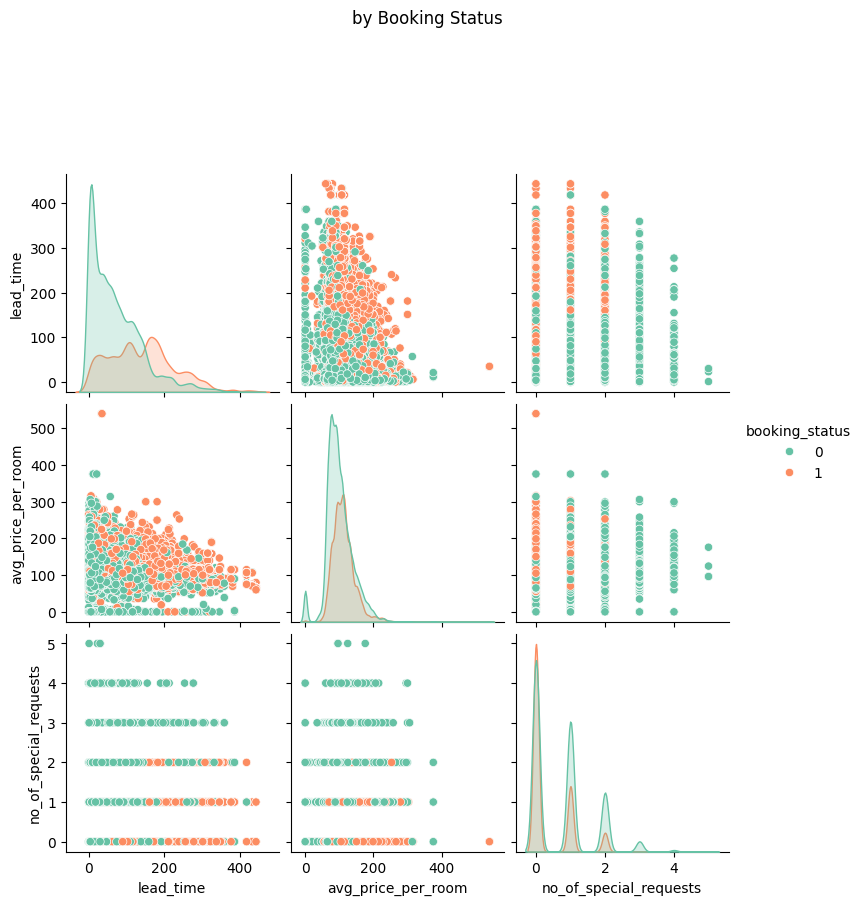

In [ ]:
plt.figure( figsize = ( 12, 8 ) )
sns.pairplot( train[ [ 'lead_time', 'avg_price_per_room', 'no_of_special_requests', 'booking_status' ] ], hue = 'booking_status' )
plt.suptitle( 'by Booking Status', y = 1.2 )
plt.show( )

### 예약 취소 시 속성 분포

In [ ]:
import warnings
warnings.filterwarnings( 'ignore' )

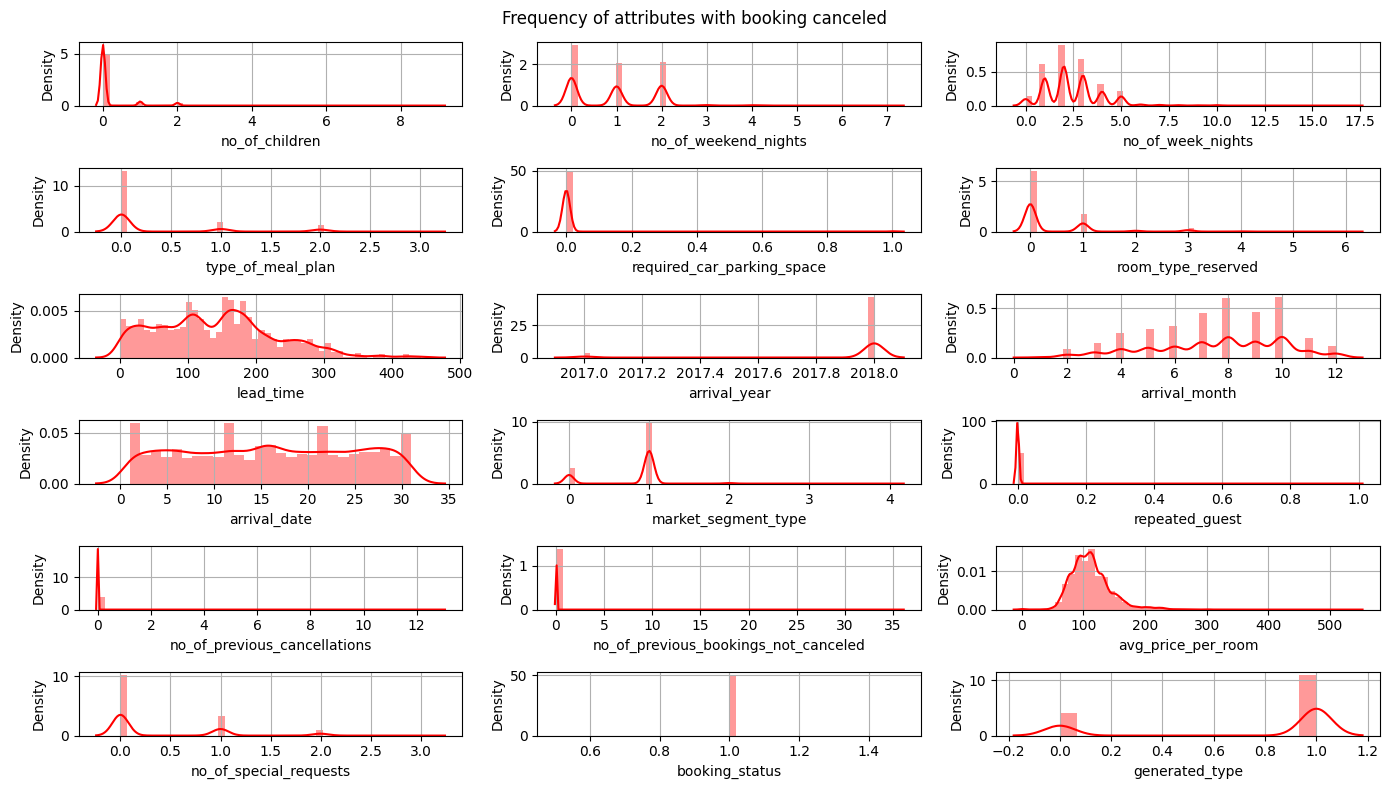

In [ ]:
# 예약이 취소된 경우에 대한 각 속성의 분포를 시각화하여 데이터의 특성을 탐색

plt.figure( figsize = ( 14, 8 ) )
plt.suptitle( 'Frequency of attributes with booking canceled' )

# train 데이터프레임에서 booking_status가 1( 예약 취소 )인 행만을 선택하여 temp에 저장
temp = train[ train.booking_status == 1 ]

for i, col in enumerate( list( temp.iloc[ : , 1 : ].columns.values ) ):
  plt.subplot( 6, 3, i + 1 )
  sns.distplot( temp[ col ], color = 'r', kde = True )
  plt.grid( )
  plt.tight_layout( )

In [ ]:
# prompt: 예약이 취소된 경우에 대한 각 속성의 분포를 시각화한  그래프를 한글로 해석해줘

예약이 취소된 경우에 대한 각 속성의 분포는 다음과 같습니다.

* **성인 수:** 예약이 취소된 경우 성인 수가 2명인 경우가 가장 많습니다.
* **어린이 수:** 예약이 취소된 경우 어린이 수가 0명인 경우가 가장 많습니다.
* **주말 숙박 수:** 예약이 취소된 경우 주말 숙박 수가 0박인 경우가 가장 많습니다.
* **주중 숙박 수:** 예약이 취소된 경우 주중 숙박 수가 2박인 경우가 가장 많습니다.
* **식사 계획:** 예약이 취소된 경우 식사 계획이 풀보드인 경우가 가장 많습니다.
* **주차 공간 필요 여부:** 예약이 취소된 경우 주차 공간이 필요없는 경우가 가장 많습니다.
* **예약한 객실 유형:** 예약이 취소된 경우 예약한 객실 유형이 스탠다드인 경우가 가장 많습니다.
* **예약 리드 타임:** 예약이 취소된 경우 예약 리드 타임이 0일인 경우가 가장 많습니다.
* **도착 연도:** 예약이 취소된 경우 도착 연도가 2015년인 경우가 가장 많습니다.
* **도착 월:** 예약이 취소된 경우 도착 월이 7월인 경우가 가장 많습니다.
* **도착 날짜:** 예약이 취소된 경우 도착 날짜가 1일인 경우가 가장 많습니다.
* **마케팅 세그먼트 유형:** 예약이 취소된 경우 마케팅 세그먼트 유형이 온라인인 경우가 가장 많습니다.
* **반복 고객 여부:** 예약이 취소된 경우 반복 고객이 아닌 경우가 가장 많습니다.
* **이전 취소 건수:** 예약이 취소된 경우 이전 취소 건수가 0회인 경우가 가장 많습니다.
* **이전 예약 건수( 취소 제외 ):** 예약이 취소된 경우 이전 예약 건수( 취소 제외 )가 0회인 경우가 가장 많습니다.
* **객실당 평균 가격:** 예약이 취소된 경우 객실당 평균 가격이 100달러 이하인 경우가 가장 많습니다.
* **특별 요청 수:** 예약이 취소된 경우 특별 요청 수가 0개인 경우가 가장 많습니다.


### 예약 상태와 특성 간의 상호 정보량 시각화

In [ ]:
from sklearn.feature_selection import mutual_info_classif

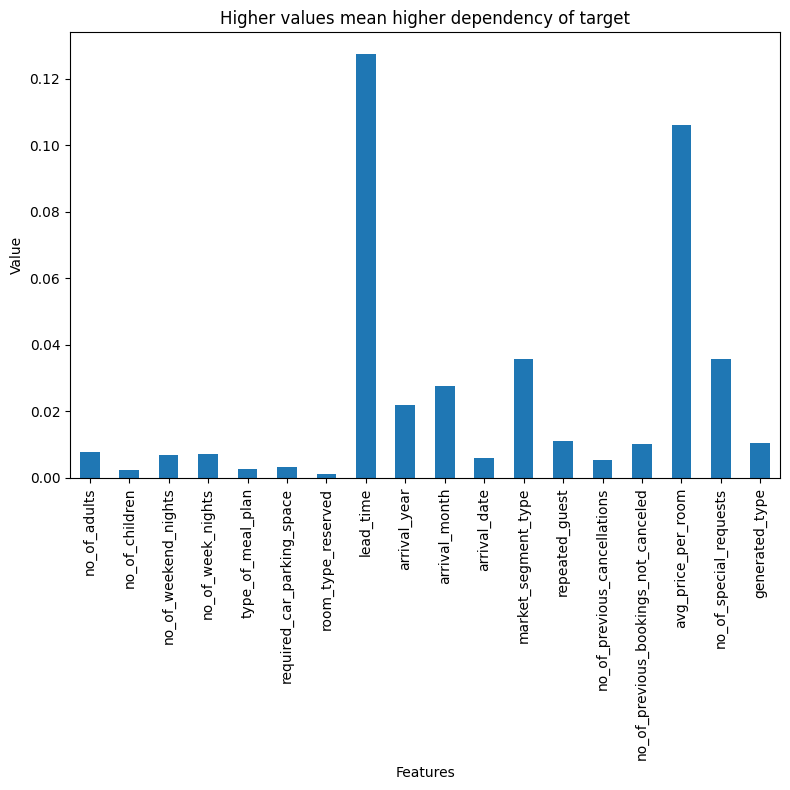

In [ ]:
fe_mi = train.drop( columns = [ 'booking_status' ] ).columns.to_list( )
mi = mutual_info_classif( train[ fe_mi ], train[ 'booking_status' ].values,
                         discrete_features = 'auto', n_neighbors = 3, copy = True, random_state = None)
df_mi = pd.DataFrame( [ mi ], columns = fe_mi )



ax = df_mi.transpose( ).plot.bar( figsize = ( 8, 8 ), legend = False )
ax.set_xlabel( 'Features' )
ax.set_ylabel( 'Value' )
ax.set_title( 'Higher values mean higher dependency of target' )
plt.tight_layout( )
plt.show( )

In [ ]:
cate_features = [
    'no_of_adults',
    'no_of_children',
    'type_of_meal_plan',
    'required_car_parking_space',
    'room_type_reserved',
    'arrival_year',
    'market_segment_type',
    'repeated_guest',
    'no_of_special_requests',
    'booking_status' ]
numeric_features = list( set ( train.columns )  - set( cate_features ) )

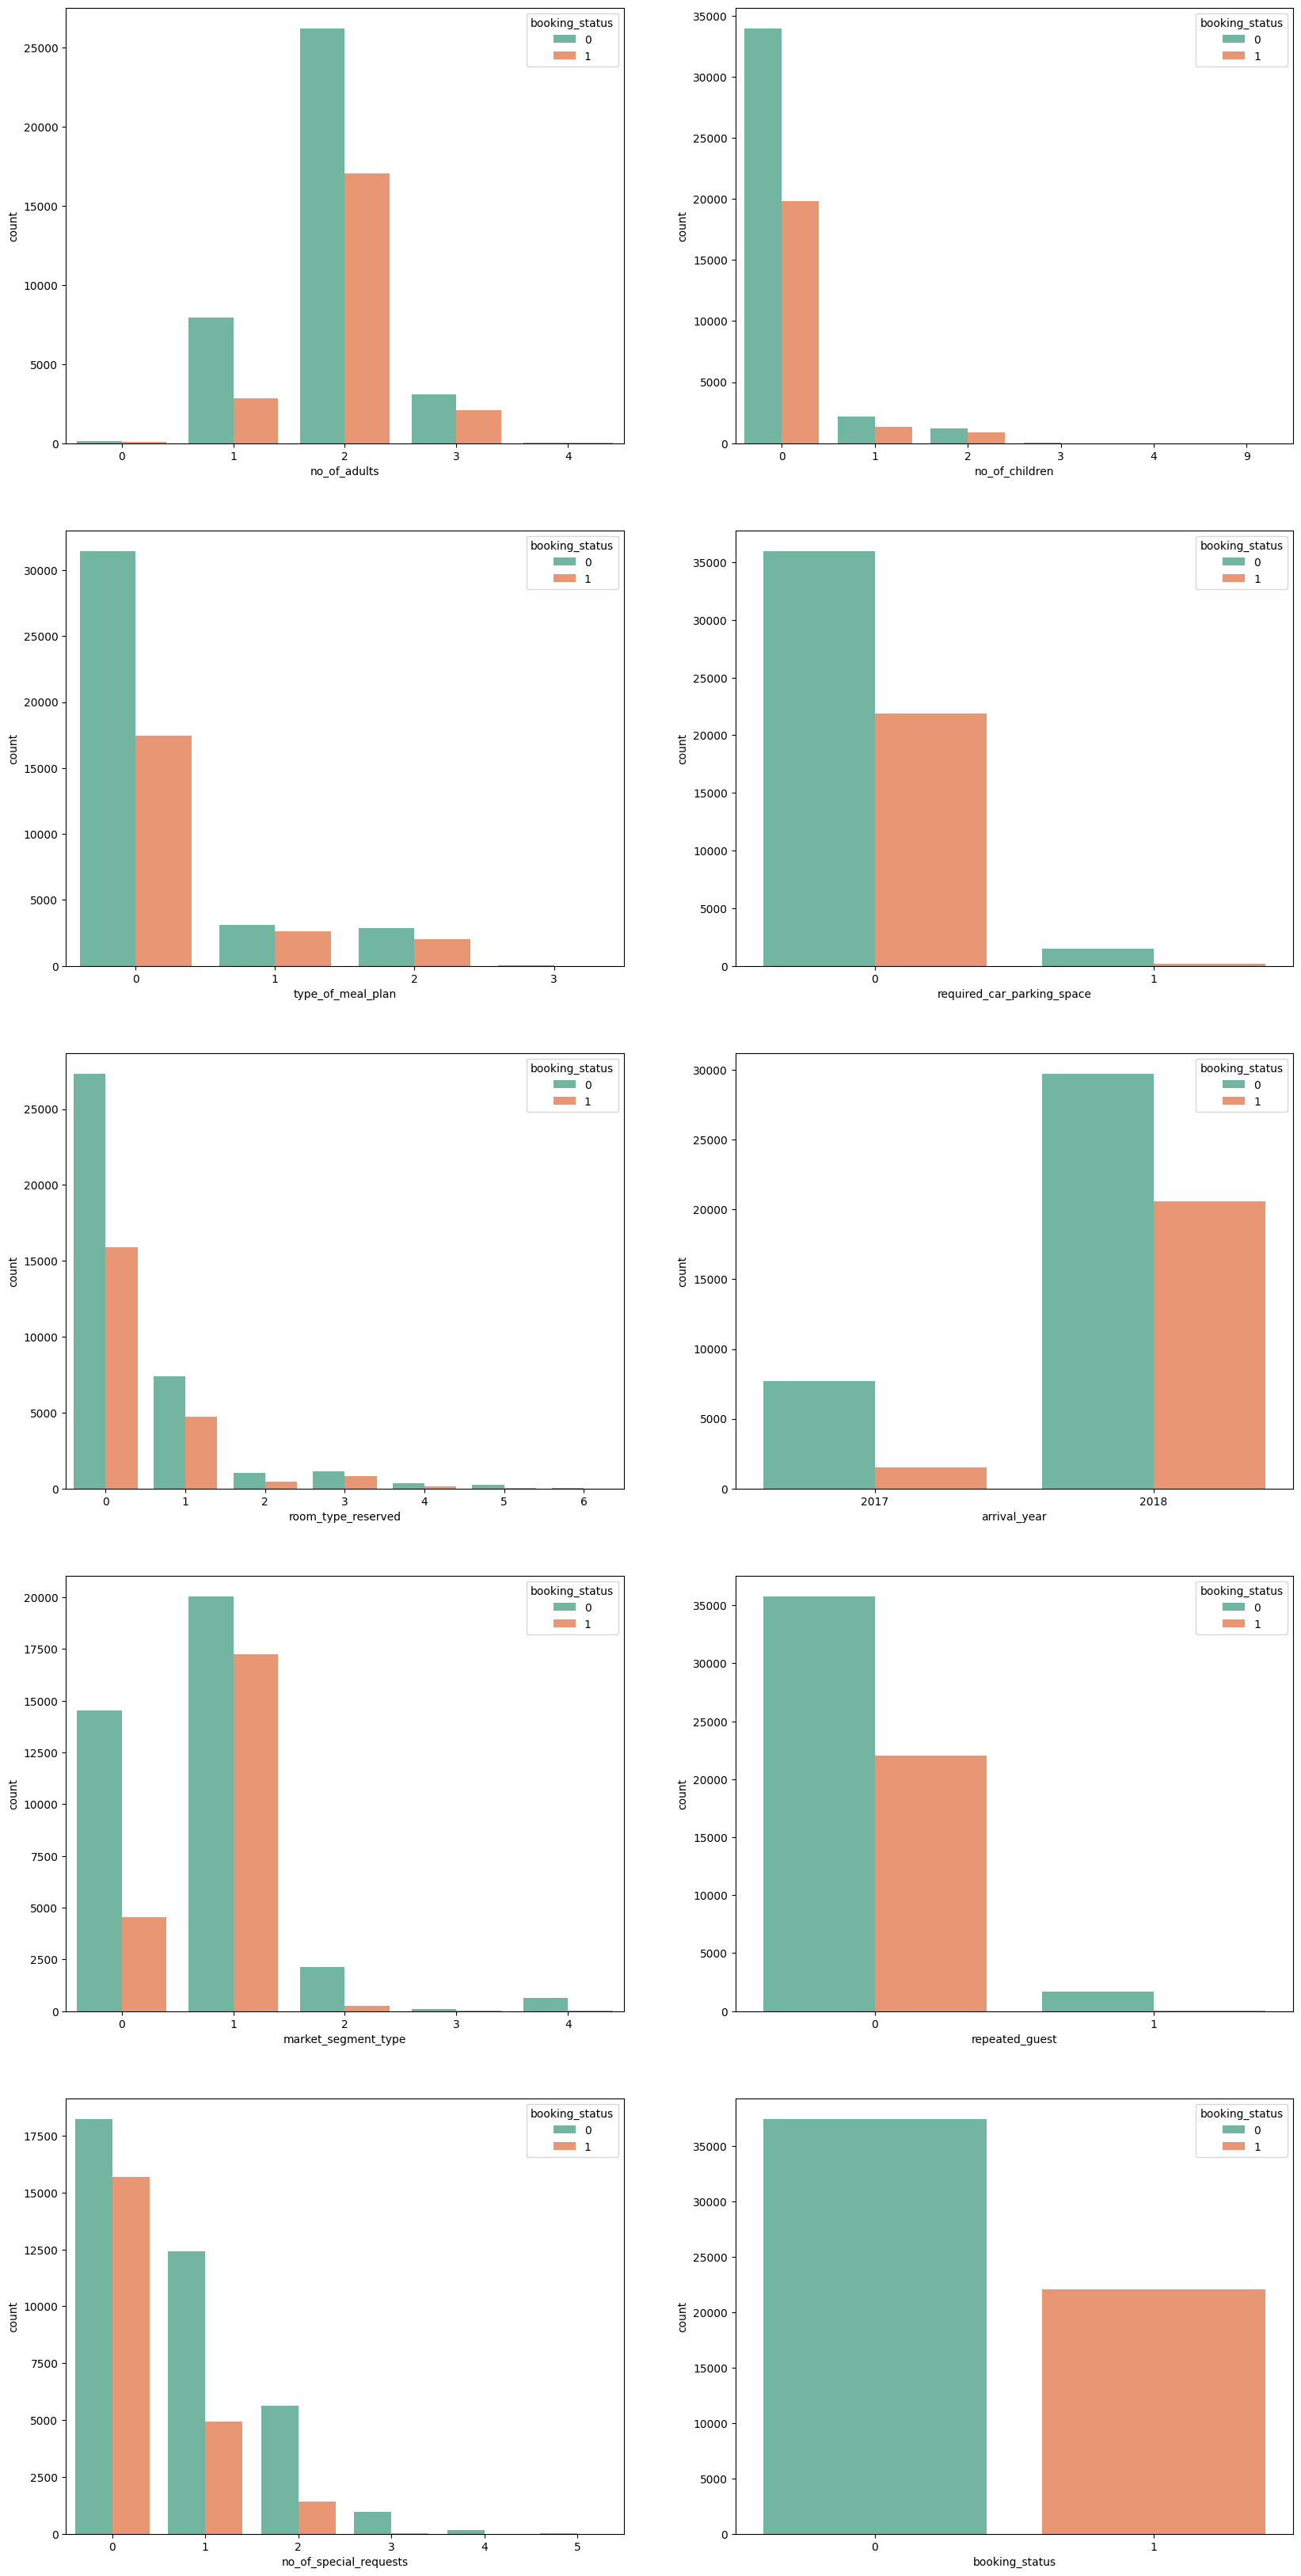

In [ ]:
plt.figure( figsize = ( 20, 50 ) )
sns.set_palette( 'Set2' )

for i, feature in enumerate( cate_features ):
    plt.subplot( len( cate_features ) // 2 + 1, 2, i + 1 )
    sns.countplot( data = train, x = feature, hue = 'booking_status' )
plt.show( )

### 예약 상태의 높은 의존성에 따른 박스 플롯

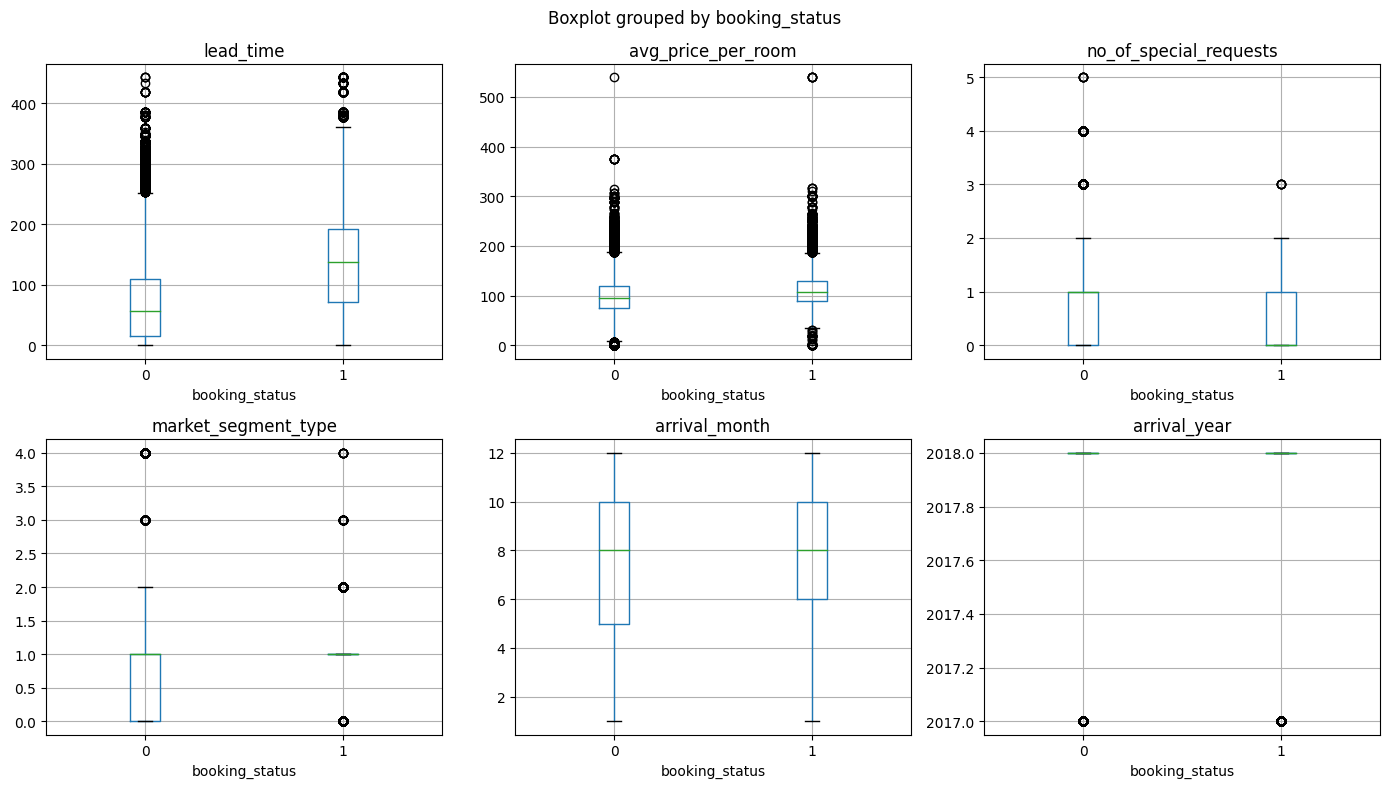

In [ ]:
temp = df_mi.T.rename( columns = { 0 : 'value' } )
feat_hi_depend = temp.nlargest( 6,'value' ).index.tolist( )

fig, axes = plt.subplots( 2, 3, figsize = ( 14, 8 ) ) # create figure and axes

for i,el in enumerate( feat_hi_depend ):
  a = train.boxplot( el, by = 'booking_status', ax = axes.flatten( )[ i ] )

#fig.delaxes(axes[1,1]) # remove empty subplot
plt.tight_layout( )
plt.show( )

### 상관 관계 히트맵

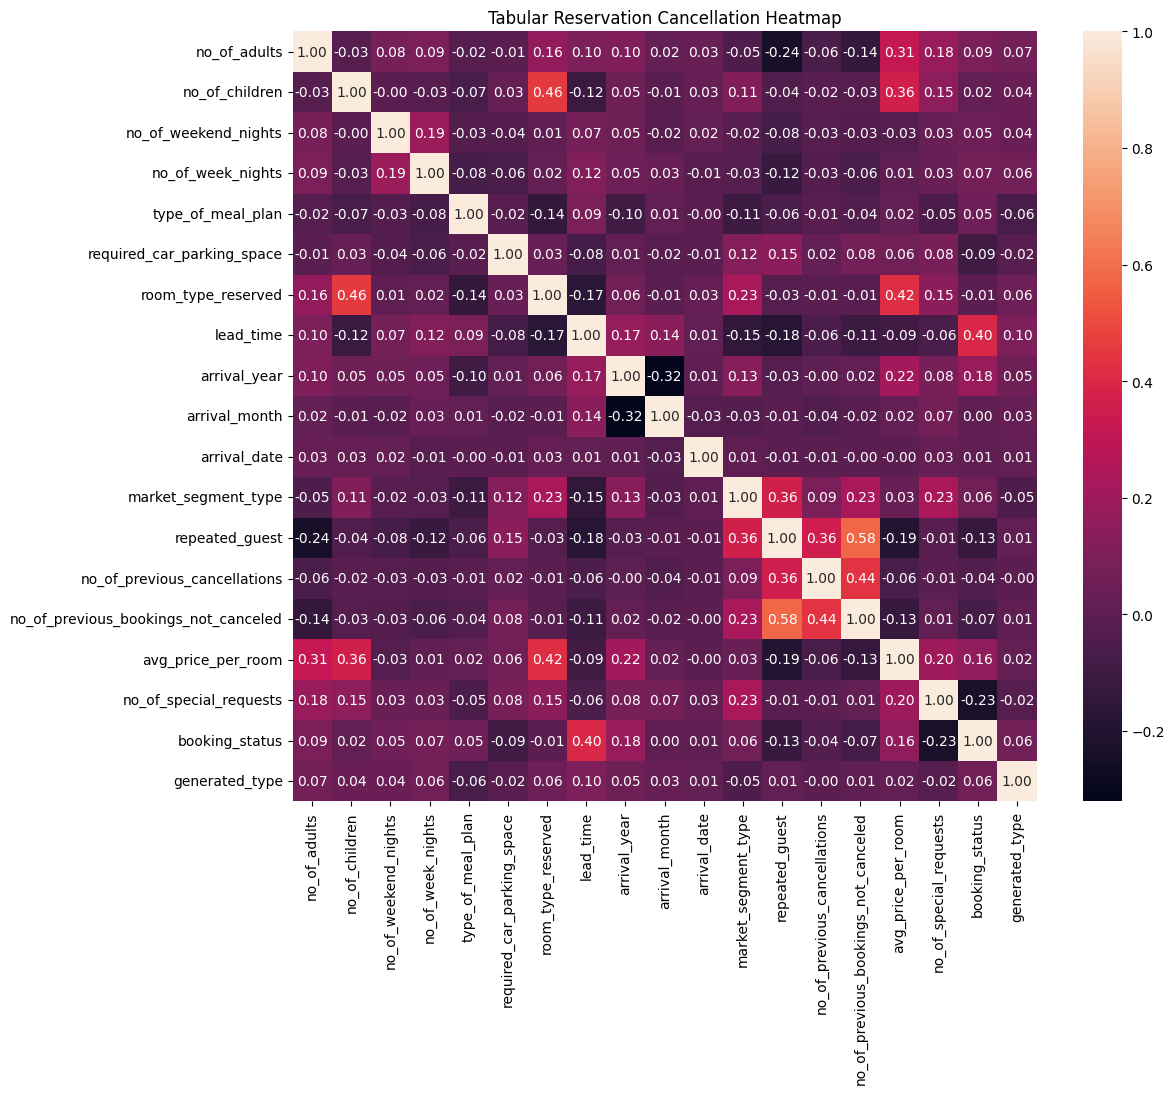

In [ ]:
# 상관 관계 계산
correlation = train.corr( )

# 상관관계 히트맵 그리기
plt.figure( figsize = ( 12, 10 ) )
sns.heatmap( correlation, annot = True, fmt = ".2f" )
plt.title( 'Tabular Reservation Cancellation Heatmap' )
plt.show( )

### 예약 상태와 식사 예약

In [ ]:
def display_tabular_relationship_cate_target( df, feature ):
  display( pd.crosstab( index = df[ 'booking_status' ],
                        columns = df[ feature ],
                        normalize = 'columns' ) )

In [ ]:
display_tabular_relationship_cate_target( train, 'type_of_meal_plan' )

type_of_meal_plan,0,1,2,3
booking_status,,,,
0,0.643342,0.542038,0.588655,0.888889
1,0.356658,0.457962,0.411345,0.111111


- Type_of_meal_plan이 0인 예약은 64.1%가 취소가 되었고, 나머지 35.8%는 예약됨.
- Type_of_meal_plan이 1인 예약(조식)은 54.2%가 취소가 되었고, 나머지 45.8%는 예약됨.
- Type_of_meal_plan이 2인 예약(중식)은 58.6%가 취소가 되었고, 나머지 41.4%는 예약됨.
- Type_of_meal_plan이 3인 예약(석식)은 88.89%가 취소가 되었고, 나머지 11.11%는 예약됨.
- Type_of_meal_plan이 3인 예약(석식)은 취소 가능성이 가장 높은 반면 Type_of_meal_plan 0인 예약은 취소 가능성이 가장 낮음.

## 2. 중복 데이터 삭제

### 데이터 준비

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train      = pd.read_csv( '/content/drive/MyDrive/멋사_데이터분석스쿨/9.파이널_프로젝트/Binary Classification with a Tabular Reservation Cancellation Dataset/del_train.csv' )
target = train[ 'booking_status' ]

### 범주형 변수 - 타겟 변수의 모든 표 형식

In [ ]:
for i, feature in enumerate( cate_features ):
  if i != 9:
    print( f'{feature}')
    display_tabular_relationship_cate_target( train, feature )
    print( '\n' )

no_of_adults


no_of_adults,0,1,2,3,4
booking_status,,,,,
0,0.643172,0.752026,0.617087,0.599565,0.611111
1,0.356828,0.247974,0.382913,0.400435,0.388889




no_of_children


no_of_children,0,1,2,3,4,9
booking_status,,,,,,
0,0.64207,0.625145,0.582769,0.814815,0.8,0.75
1,0.35793,0.374855,0.417231,0.185185,0.2,0.25




type_of_meal_plan


type_of_meal_plan,0,1,2,3
booking_status,,,,
0,0.651664,0.547085,0.617196,0.888889
1,0.348336,0.452915,0.382804,0.111111




required_car_parking_space


required_car_parking_space,0,1
booking_status,,
0,0.630505,0.901609
1,0.369495,0.098391




room_type_reserved


room_type_reserved,0,1,2,3,4,5,6
booking_status,,,,,,,
0,0.645618,0.611635,0.679286,0.5861,0.751185,0.856604,0.666667
1,0.354382,0.388365,0.320714,0.4139,0.248815,0.143396,0.333333




arrival_year


arrival_year,2017,2018
booking_status,,
0,0.848819,0.603038
1,0.151181,0.396962




market_segment_type


market_segment_type,0,1,2,3,4
booking_status,,,,,
0,0.80514,0.544698,0.900574,0.808333,0.988818
1,0.19486,0.455302,0.099426,0.191667,0.011182




repeated_guest


repeated_guest,0,1
booking_status,,
0,0.62757,0.990226
1,0.37243,0.009774




no_of_special_requests


no_of_special_requests,0,1,2,3,4,5
booking_status,,,,,,
0,0.539599,0.724715,0.801122,0.994731,1.0,1.0
1,0.460401,0.275285,0.198878,0.005269,0.0,0.0


### 예약 상태의 비율 바차트

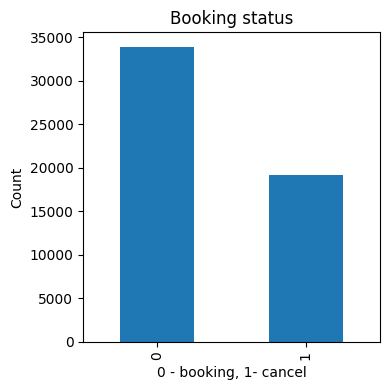

In [ ]:
ax = target.value_counts( ).plot.bar( figsize = ( 4, 4 ), legend = False )
ax.set_title( 'Booking status' )
ax.set_xlabel( '0 - booking, 1- cancel' )
ax.set_ylabel( 'Count' )
plt.tight_layout( )
plt.show( )

### 예약 상태와 특성

<Figure size 1200x800 with 0 Axes>

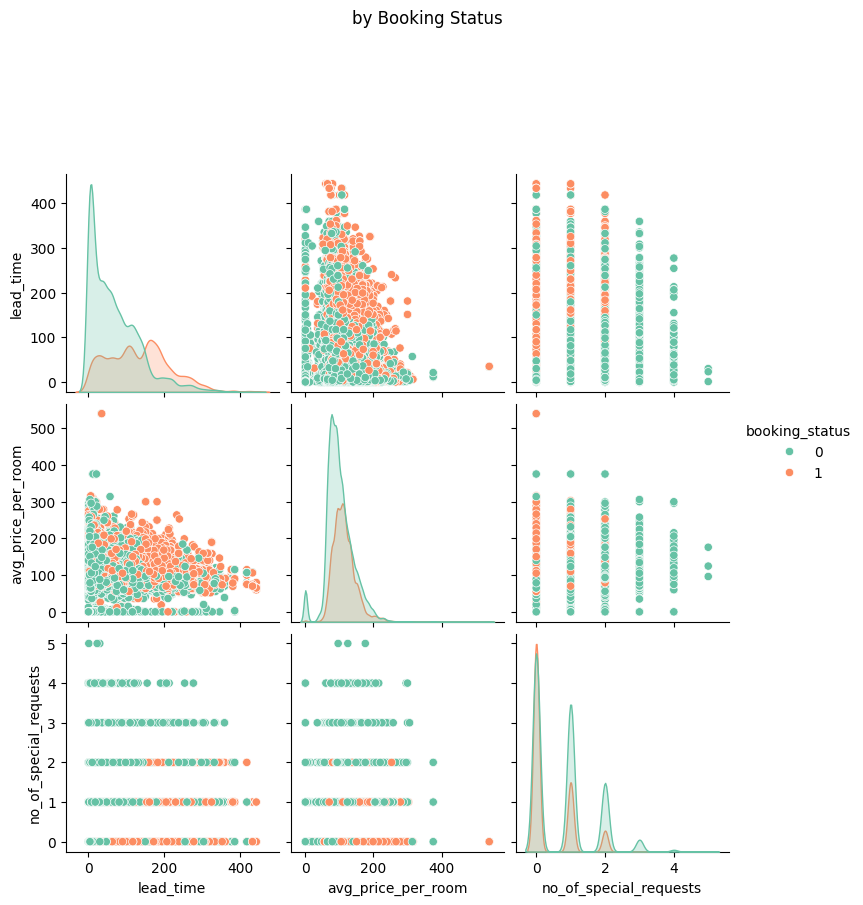

In [ ]:
plt.figure( figsize = ( 12, 8 ) )
sns.pairplot( train[ [ 'lead_time', 'avg_price_per_room',
                       'no_of_special_requests', 'booking_status' ] ],
              hue = 'booking_status' )

plt.suptitle( 'by Booking Status', y = 1.2 )
plt.show( )

### 예약 취소 시 속성 분포

In [ ]:
import warnings
warnings.filterwarnings( 'ignore' )

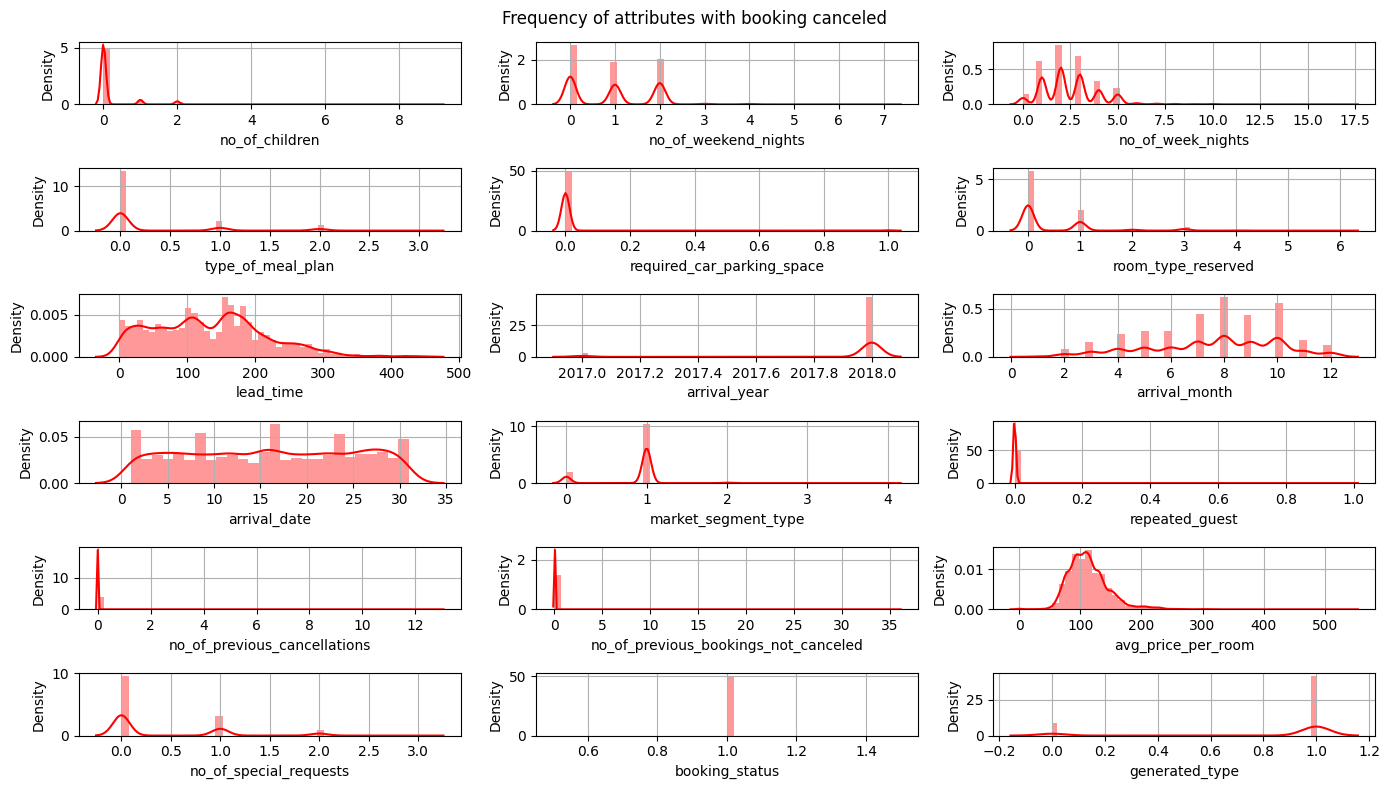

In [ ]:
# 예약이 취소된 경우에 대한 각 속성의 분포를 시각화하여 데이터의 특성을 탐색

plt.figure( figsize = ( 14, 8 ) )
plt.suptitle( 'Frequency of attributes with booking canceled' )

# train 데이터프레임에서 booking_status가 1(예약 취소)인 행만을 선택하여 temp에 저장
temp = train[ train.booking_status == 1 ]

for i, col in enumerate( list( temp.iloc[ : , 1 : ].columns.values ) ):
  plt.subplot( 6, 3, i + 1 )
  sns.distplot( temp[ col ], color = 'r', kde = True )
  plt.grid( )
  plt.tight_layout( )

In [ ]:
# prompt: 예약이 취소된 경우에 대한 각 속성의 분포를 시각화 한 그래프를 한글로 해석해줘

* 성인 수: 예약이 취소된 경우 성인 수가 2명인 경우가 가장 많습니다.
* 어린이 수: 예약이 취소된 경우 어린이 수가 0명인 경우가 가장 많습니다.
* 주말 숙박 수: 예약이 취소된 경우 주말 숙박 수가 0박인 경우가 가장 많습니다.
* 주중 숙박 수: 예약이 취소된 경우 주중 숙박 수가 2박인 경우가 가장 많습니다.
* 식사 계획: 예약이 취소된 경우 식사 계획이 풀보드인 경우가 가장 많습니다.
* 주차 공간 필요 여부: 예약이 취소된 경우 주차 공간이 필요없는 경우가 가장 많습니다.
* 예약한 객실 유형: 예약이 취소된 경우 예약한 객실 유형이 스탠다드인 경우가 가장 많습니다.
* 예약 리드 타임: 예약이 취소된 경우 예약 리드 타임이 0일인 경우가 가장 많습니다.
* 도착 연도: 예약이 취소된 경우 도착 연도가 2015년인 경우가 가장 많습니다.
* 도착 월: 예약이 취소된 경우 도착 월이 7월인 경우가 가장 많습니다.
* 도착 날짜: 예약이 취소된 경우 도착 날짜가 1일인 경우가 가장 많습니다.
* 마케팅 세그먼트 유형: 예약이 취소된 경우 마케팅 세그먼트 유형이 온라인인 경우가 가장 많습니다.
* 반복 고객 여부: 예약이 취소된 경우 반복 고객이 아닌 경우가 가장 많습니다.
* 이전 취소 건수: 예약이 취소된 경우 이전 취소 건수가 0회인 경우가 가장 많습니다.
* 이전 예약 건수(취소 제외): 예약이 취소된 경우 이전 예약 건수(취소 제외)가 0회인 경우가 가장 많습니다.
* 객실당 평균 가격: 예약이 취소된 경우 객실당 평균 가격이 100달러 이하인 경우가 가장 많습니다.
* 특별 요청 수: 예약이 취소된 경우 특별 요청 수가 0개인 경우가 가장 많습니다.


### 예약 상태와 특성 간의 상호 정보량 시각화

In [ ]:
from sklearn.feature_selection import mutual_info_classif

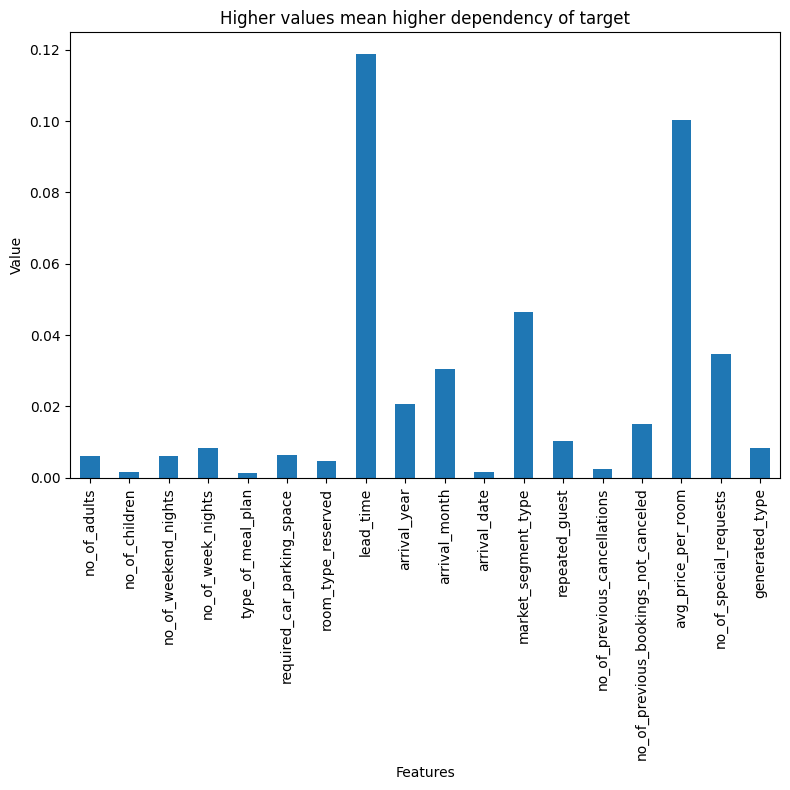

In [ ]:
fe_mi = train.drop( columns = [ 'booking_status' ] ).columns.to_list( )
mi = mutual_info_classif( train[ fe_mi ], train[ 'booking_status' ].values,
                         discrete_features = 'auto', n_neighbors = 3, copy = True, random_state = None )
df_mi = pd.DataFrame( [ mi ], columns = fe_mi )


ax = df_mi.transpose( ).plot.bar( figsize = ( 8, 8 ), legend = False )
ax.set_xlabel( 'Features' )
ax.set_ylabel( 'Value' )
ax.set_title( 'Higher values mean higher dependency of target' )
plt.tight_layout( )
plt.show( )

In [ ]:
cate_features = [
    'no_of_adults',
    'no_of_children',
    'type_of_meal_plan',
    'required_car_parking_space',
    'room_type_reserved',
    'arrival_year',
    'market_segment_type',
    'repeated_guest',
    'no_of_special_requests',
    'booking_status' ]
numeric_features = list( set ( train.columns )  - set( cate_features ) )

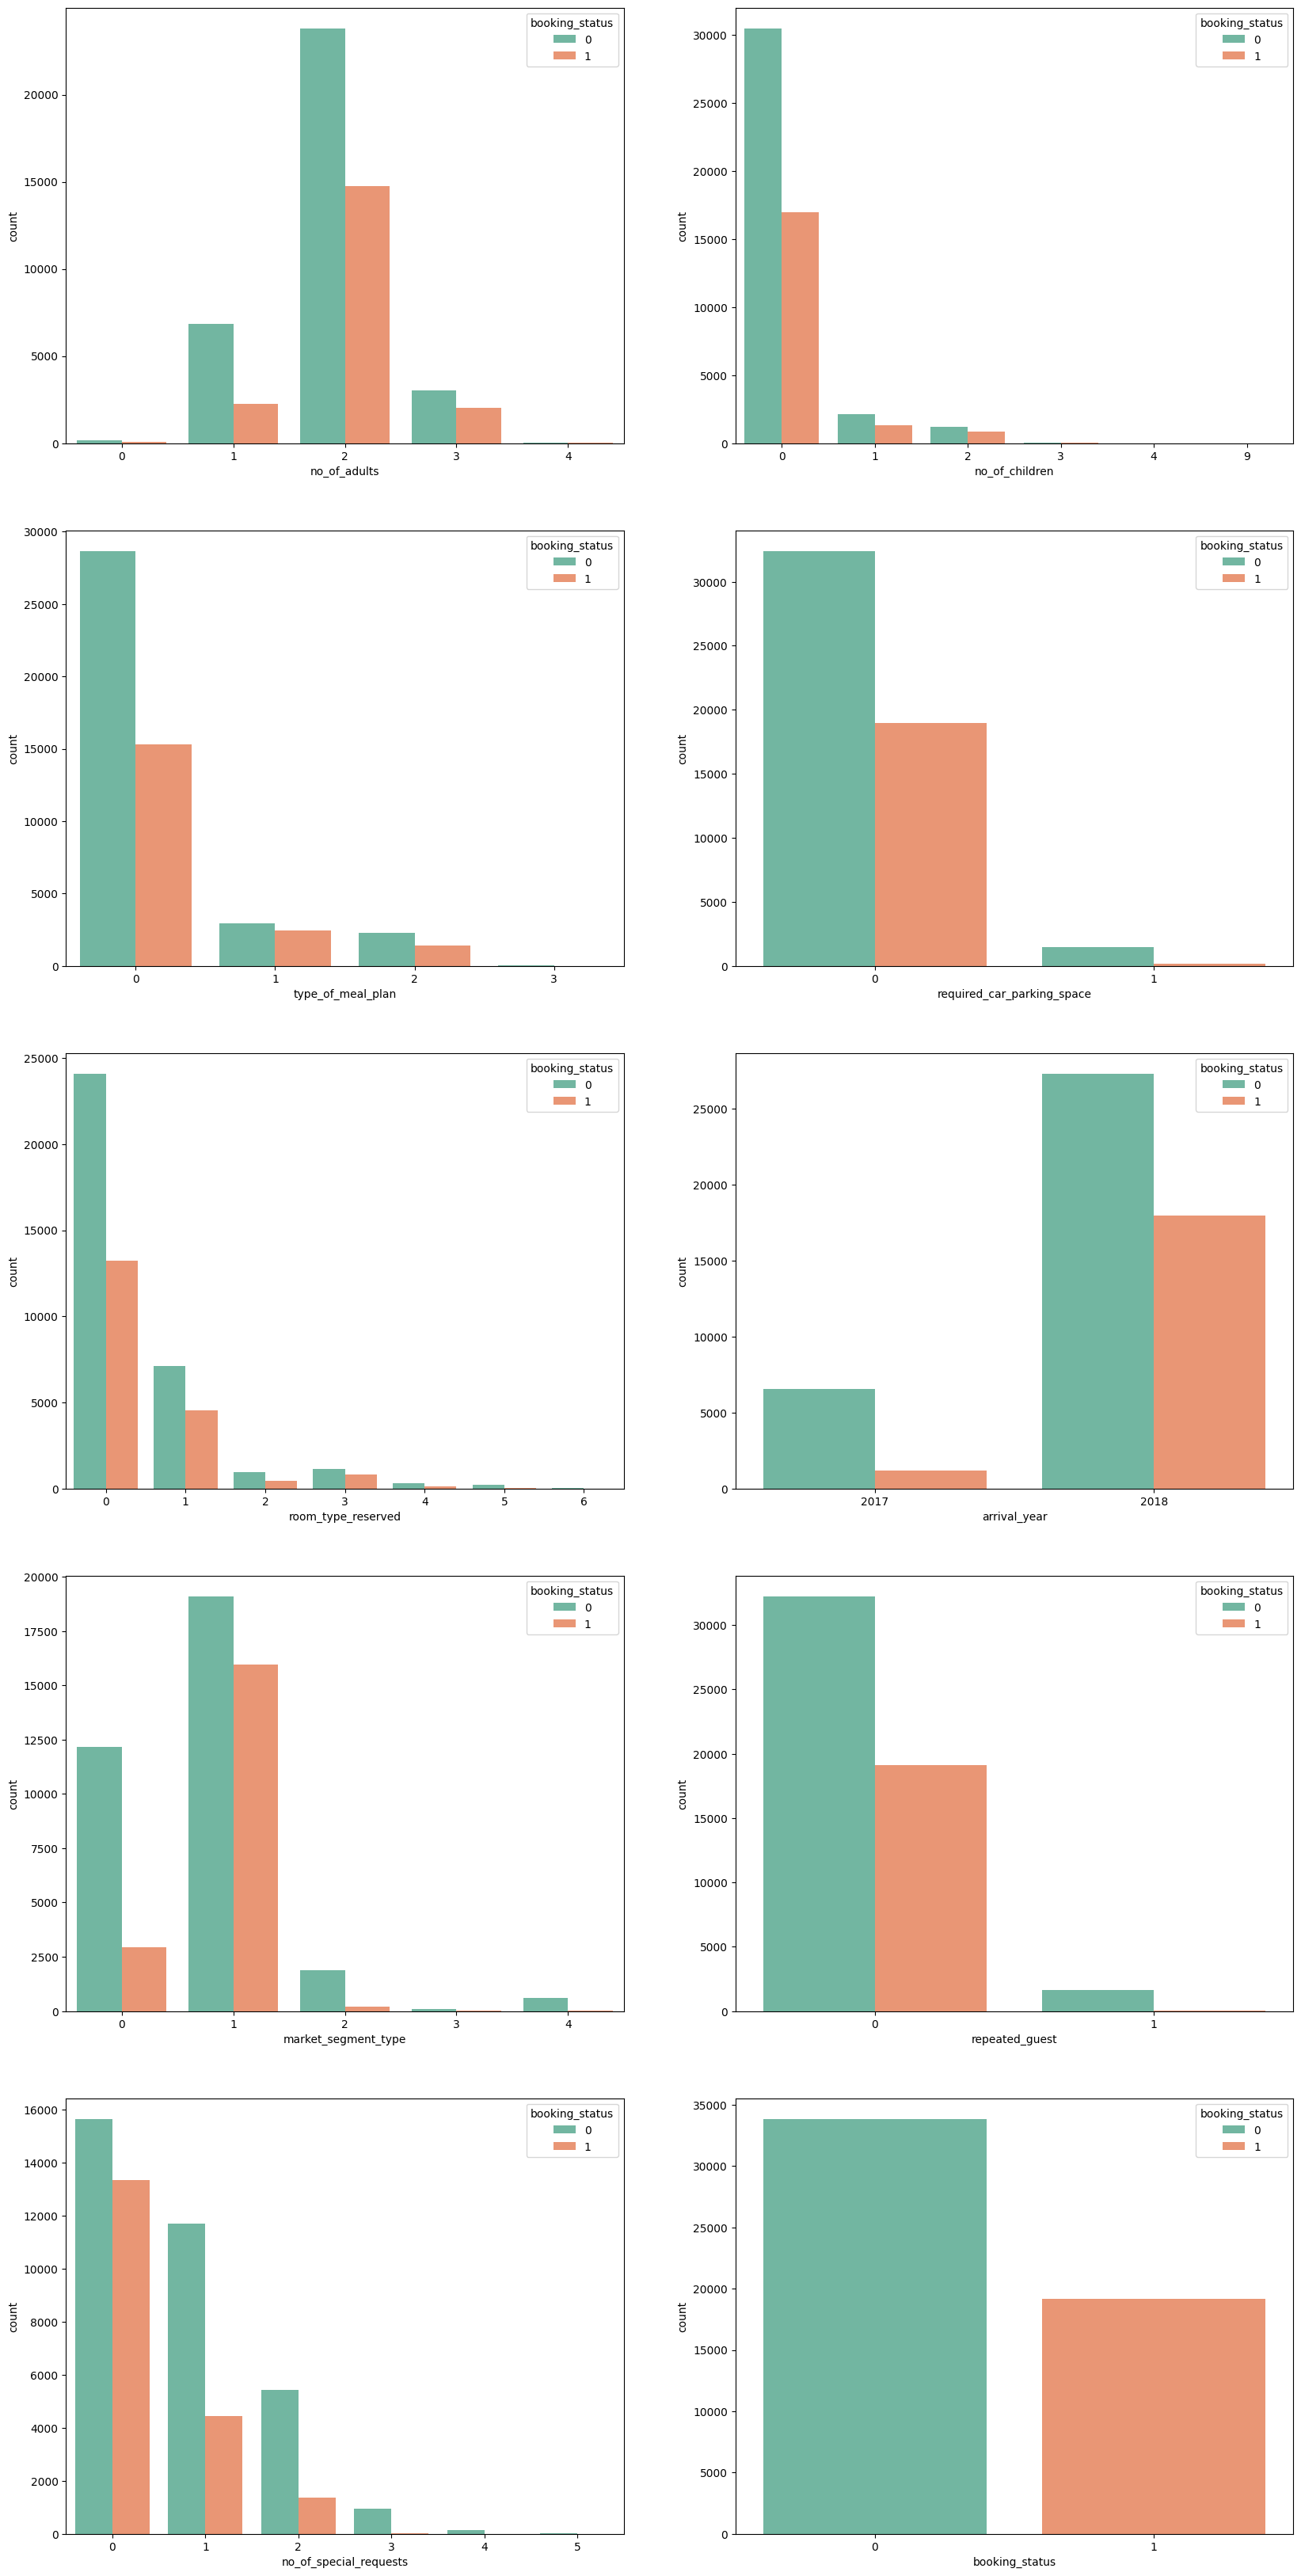

In [ ]:
plt.figure( figsize = ( 20, 50 ) )
sns.set_palette( 'Set2' )

for i, feature in enumerate( cate_features ):
    plt.subplot( len( cate_features ) // 2 + 1, 2, i + 1 )
    sns.countplot( data = train, x = feature, hue = 'booking_status' )
plt.show( )

### 예약 상태의 높은 의존성에 따른 박스 플롯

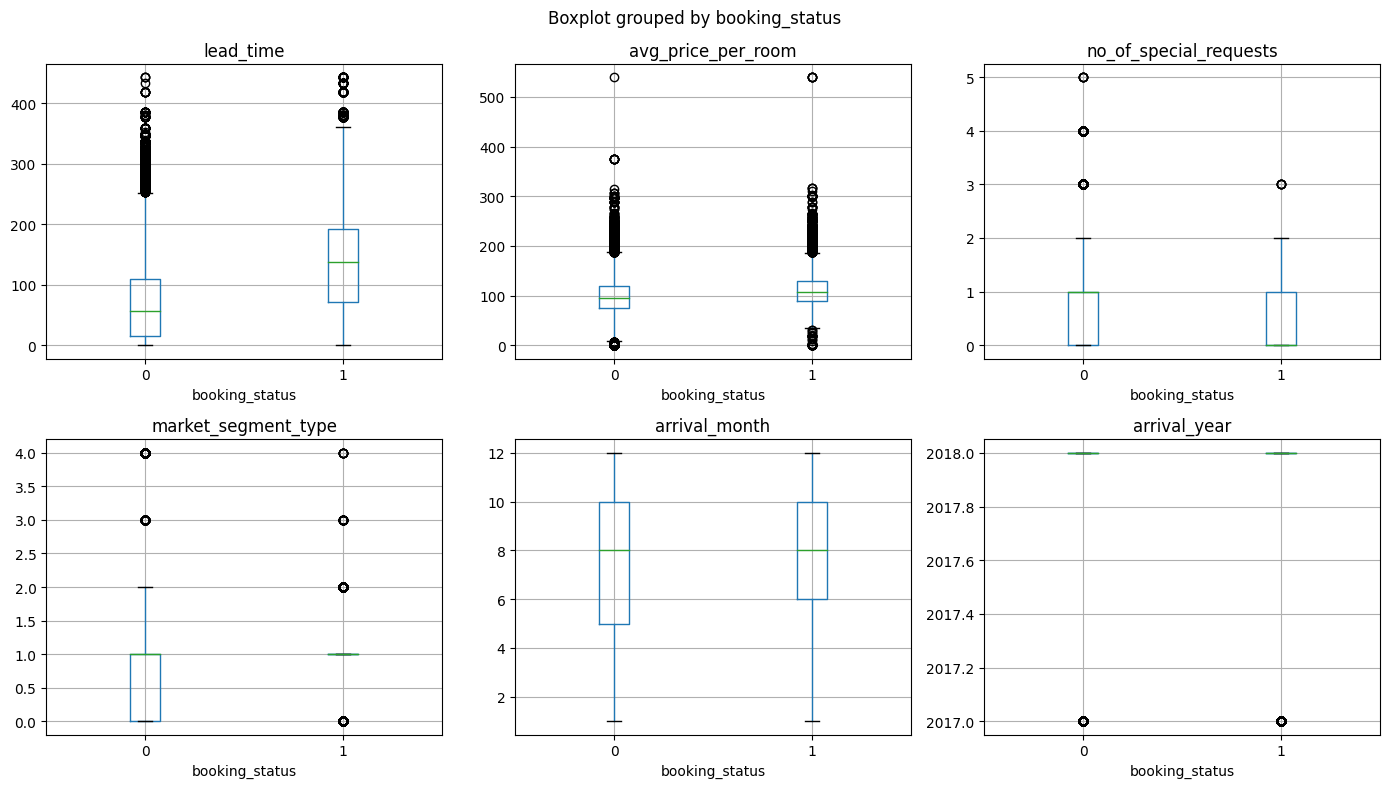

In [ ]:
temp = df_mi.T.rename( columns = { 0 : 'value' } )
feat_hi_depend = temp.nlargest( 6, 'value').index.tolist( )

fig, axes = plt.subplots( 2, 3, figsize = ( 14, 8 ) ) # create figure and axes

for i,el in enumerate( feat_hi_depend ):
  a = train.boxplot( el, by = 'booking_status', ax = axes.flatten( )[ i ] )

#fig.delaxes( axes[ 1, 1 ] ) # remove empty subplot
plt.tight_layout( )

plt.show( )

### 상관 관계 히트맵

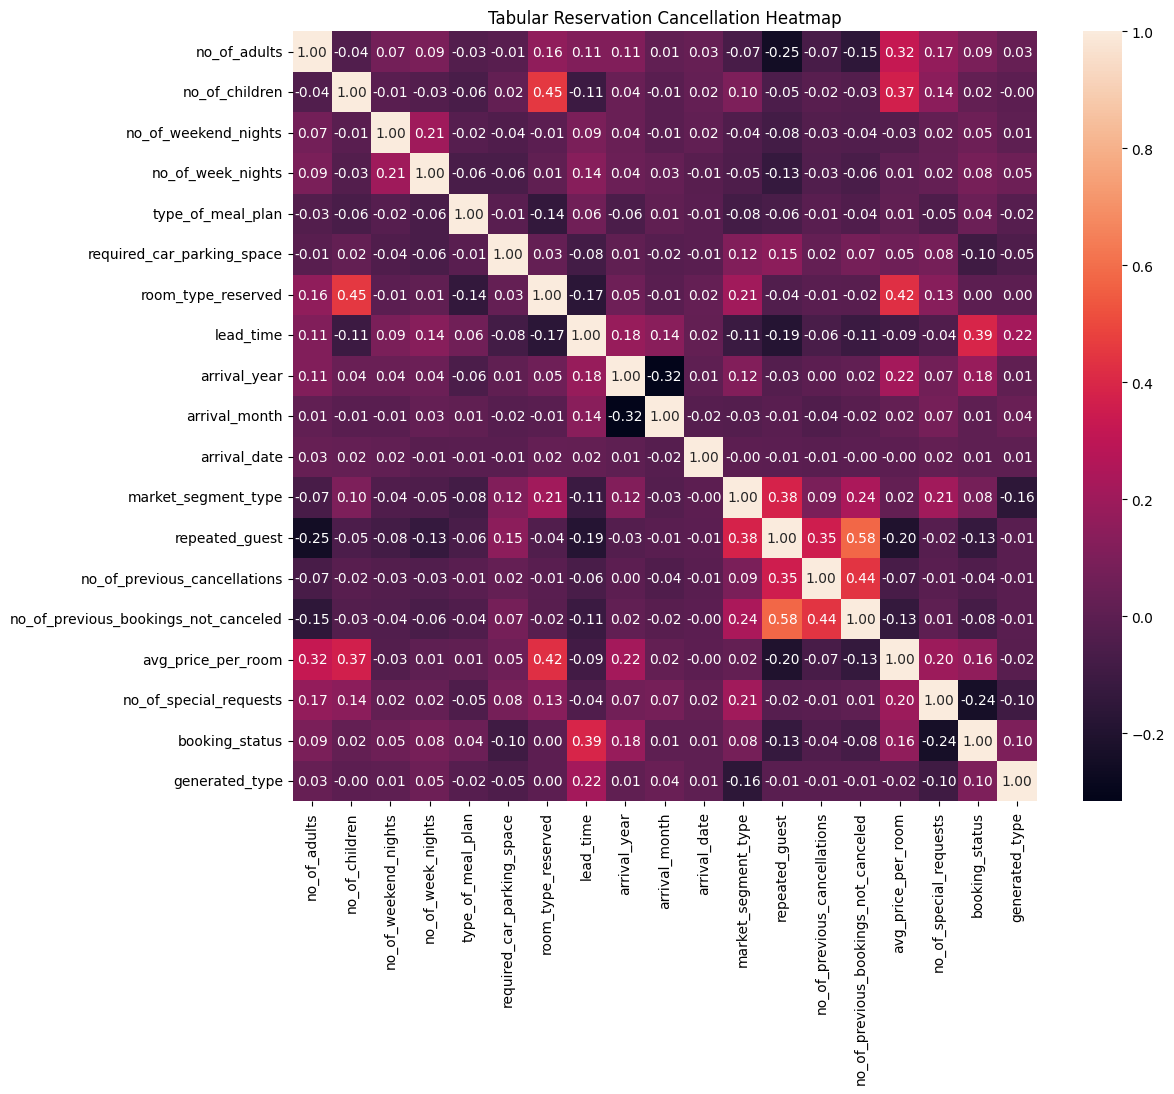

In [ ]:
# 상관 관계 계산
correlation = train.corr( )

# 상관관계 히트맵 그리기
plt.figure( figsize = ( 12, 10 ) )
sns.heatmap( correlation, annot = True, fmt = ".2f" )
plt.title( 'Tabular Reservation Cancellation Heatmap' )
plt.show( )

# 처리된 데이터 모델 학습
[처리된 데이터 모델 학습](https://colab.research.google.com/drive/1XgfTXm2DsnWENTCM7_Ztpp6-EwtyoPNU#scrollTo=Y-vHXriXfhhJ)